In [1]:
!pip -q install apyori

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize']=(15,10)

In [3]:
url = r'db/vendas_supermercado.csv'
data = pd.read_csv(url)

In [4]:
data.head()

,Produto,Quantidade,Preço Unitário,Total,Linha de Produto,Tipo de Cliente,Gênero,Cidade
0,Carne Bovina,1.0,25.0,25.0,Carnes,Pessoa Jurídica,Feminino,Rio de Janeiro
1,Sabão,1.0,8.0,8.0,Limpeza,Pessoa Jurídica,Feminino,Rio de Janeiro
2,Frango,1.0,12.0,12.0,Carnes,Pessoa Jurídica,Feminino,Rio de Janeiro
3,Detergente,1.0,3.5,3.5,Limpeza,Pessoa Jurídica,Feminino,Rio de Janeiro
4,Leite,8.0,4.5,36.0,Laticínios,Pessoa Física,Masculino,Porto Alegre


### Remover os espaços em branco das colunas

In [5]:
for index in data.columns:
    # Verifica se a coluna é do tipo String
    if data[index].dtype == 'object':
        data[index] = data[index].str.strip()

### Verificar os valores nulos em todo dataset

In [6]:
nulos = data.isnull().sum()

# Exibir as colunas com valores nulos
print(f'Valores nulos em cada coluna: \n\n{nulos[nulos > 0]}')

Valores nulos em cada coluna: 

Quantidade    713
Cidade        660
dtype: int64


### Verificar quantos produtos distintos existem na coluna produtos

In [7]:
if 'Produto' in data.columns:
    itens = data['Produto'].dropna().sort_values()
    print(f'\nExistem {itens.nunique()} produtos distintos:\n\n {itens.unique()}')
else:
    print('A coluna Produto não foi encontrada!!')


Existem 10 produtos distintos:

 ['Arroz' 'Biscoito' 'Carne Bovina' 'Detergente' 'Feijão' 'Frango'
 'Iogurte' 'Leite' 'Pão' 'Sabão']


### Checar a duplicidade de valores

In [8]:
print('Checando duplicidade de valores')
print(data.duplicated().value_counts())

Checando duplicidade de valores
True     30262
False     2900
Name: count, dtype: int64


### Buscar os itens mais vendidos

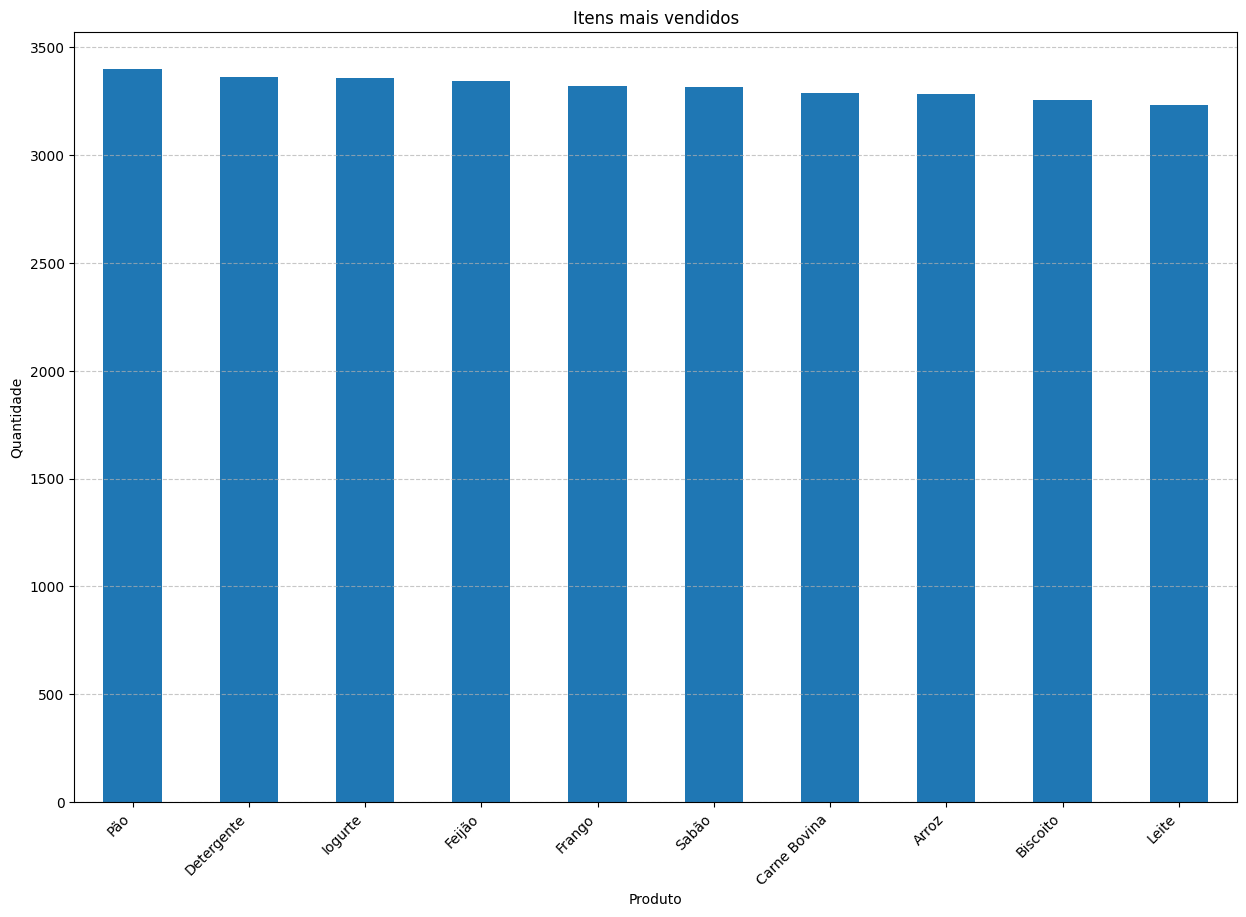

In [9]:
qtd_itens = itens.value_counts()

qtd_itens.nlargest(10).plot(kind='bar')

# Rotular o Gráfico

plt.title('Itens mais vendidos')
plt.xlabel('Produto')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Buscar os itens menos vendidos

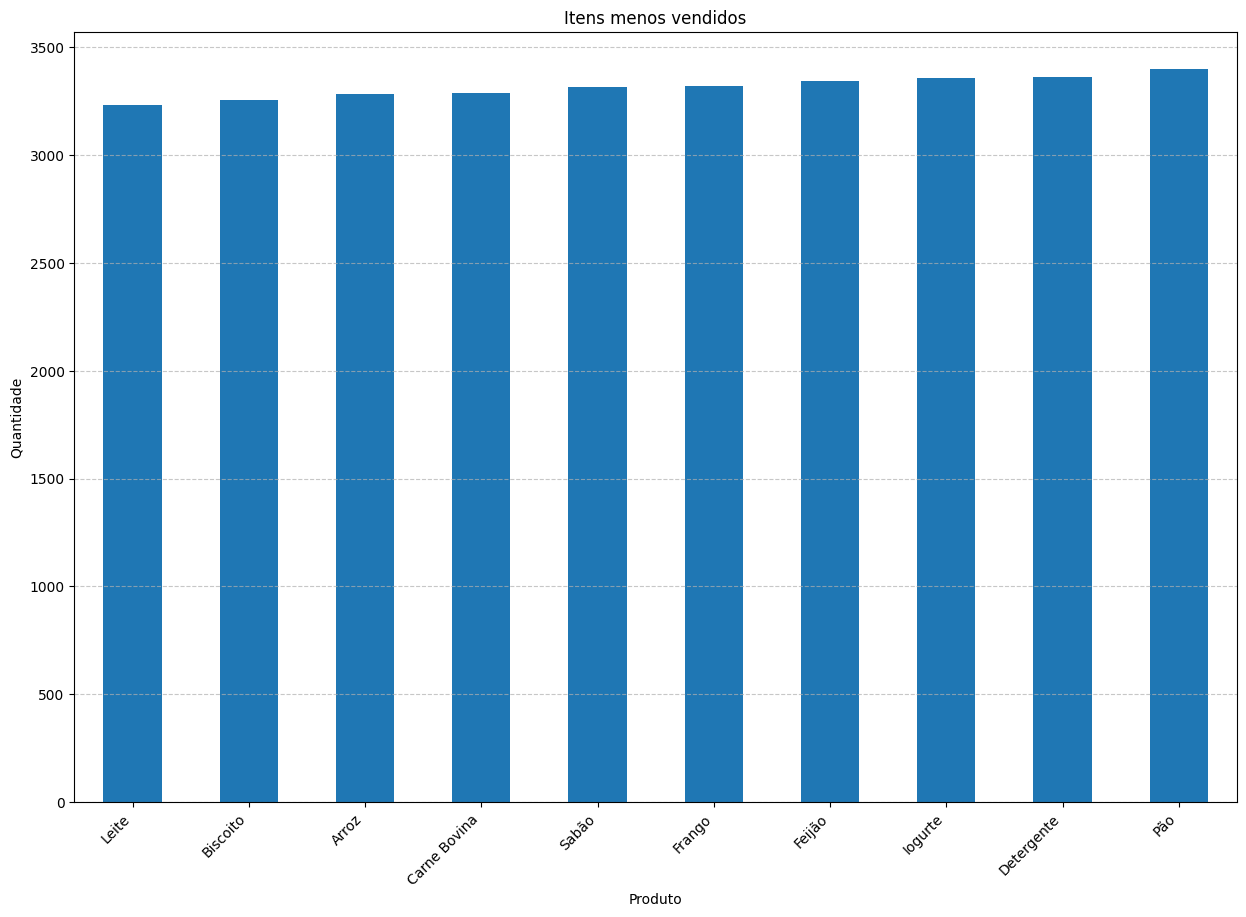

In [10]:
qtd_itens = itens.value_counts()

qtd_itens.nsmallest(10).plot(kind='bar')

# Rotular o Gráfico

plt.title('Itens menos vendidos')
plt.xlabel('Produto')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Agrupar os itens comprados por cestas

In [11]:
from itertools import combinations
from tqdm import tqdm

# Adicionar uma coluna de id de venda
data['ID de Venda'] = data.groupby(['Linha de Produto', 'Tipo de Cliente', 'Gênero']).ngroup()

# Agrupar os produtos por ID de Venda e filtrando cestas com mais de 1 item
cestas = data.groupby('ID de Venda')['Produto'].apply(list)

# Filtrar cestas com mais de 1 produto
cestas = cestas[cestas.apply(len)>1]

# Armazenar a contagem das combinações
contagem = {}

# Tamanhos das combinações desejadas
tamanhos = [2]
total_cestas = len(cestas)

with tqdm(total=total_cestas) as pbar:
    # Gerando combinações para cada cesta e contando diretamente
    for cesta in cestas:
        for tamanho in tamanhos:
            if len(cestas) >= tamanho:
                for combinacao in combinations(cesta, tamanho):
                    if combinacao in contagem:
                        contagem[combinacao] += 1
                    else:
                        contagem[combinacao] = 1
                
                # Atualizar a barra de progresso
                pbar.update(1)

# Selecionar as 10 combinações mais frequentes
top_combinacao = sorted(contagem.items(), key=lambda item:item[1], reverse = True)[:10]

# Selecionar as combinações mais frequentes
bottom_combinacoes = sorted(contagem.items(), key=lambda item:item[1])[:10]

print('\nCombinações Comuns: ')
for combinacao, frequencia in top_combinacao:
    print(f'{combinacao}:{frequencia}')

print('\nCombinações Improváveis: ')
for combinacao, frequencia in bottom_combinacoes:
    print(f'{combinacao}: {frequencia}')

100%|██████████| 24/24 [00:09<00:00,  2.60it/s]


Combinações Comuns: 
('Pão', 'Pão'):1445593
('Sabão', 'Detergente'):1416660
('Detergente', 'Detergente'):1410523
('Iogurte', 'Iogurte'):1409831
('Feijão', 'Feijão'):1396463
('Arroz', 'Feijão'):1392930
('Frango', 'Frango'):1377977
('Sabão', 'Sabão'):1373102
('Leite', 'Iogurte'):1368520
('Detergente', 'Sabão'):1367733

Combinações Improváveis: 
('Leite', 'Leite'): 1305116
('Biscoito', 'Biscoito'): 1326224
('Iogurte', 'Leite'): 1346689
('Arroz', 'Arroz'): 1347763
('Carne Bovina', 'Carne Bovina'): 1351588
('Feijão', 'Arroz'): 1353491
('Carne Bovina', 'Frango'): 1363430
('Frango', 'Carne Bovina'): 1366826
('Detergente', 'Sabão'): 1367733
('Leite', 'Iogurte'): 1368520


#### Supondo que 'cestas' seja uma lista de listas, cada sublista é uma cesta de produtos

Converter os objetos em série para uma lista com as listas

In [20]:
from apyori import apriori

cestas_list = cestas.tolist()

# Gerar regras de associação
regras = apriori(cestas_list, min_support=0.01, min_confidence=0.5, min_lift=1.5, min_lenght=2)

# Converter as regras para uma lista
resultados = list(regras)

# Criar uma listapara armazenar os dados das regras
itens_comprados = []
suportes = []
confiancas = []

# Etrair dados das regras
for resultado in resultados:
    itens = list(resultado.items)
    suporte = resultado.support

    # Extrair a confiança da primeira estatística da regra
    confianca = resultado.ordered_statistics[0].confidence if resultado.ordered_statistics else 0

    # Adicionar dados a lista (Convertendo os itens para uma string)
    itens_comprados.append(', '.join(itens))
    suportes.append(suporte)
    confiancas.append(confianca)

# Criar um DataFrame para exibir os resultados em forma de tabela
tabela_regras = pd.DataFrame({
    'Produtos comprados juntos: ': itens_comprados,
    'Suporte: ': suportes,
    'Confiança: ': confiancas
})

# Selecionar as 10 combinações mais frequentes
comb_comuns = tabela_regras.nlargest(10, 'Suporte: ')

# Selecionar as 10 combinações menos frequentes
comb_incomuns = tabela_regras.nsmallest(10, 'Suporte: ')

# Exibir as combinações comuns
print('\nCombinações comuns: ')
print(comb_comuns)

# # Exibir as combinações incomuns
# print('\nCombinações incomuns: ')
# print(comb_incomuns)


Combinações comuns: 
  Produtos comprados juntos:   Suporte:   Confiança: 
0               Arroz, Feijão   0.166667          1.0
1        Carne Bovina, Frango   0.166667          1.0
2           Sabão, Detergente   0.166667          1.0
3              Leite, Iogurte   0.166667          1.0


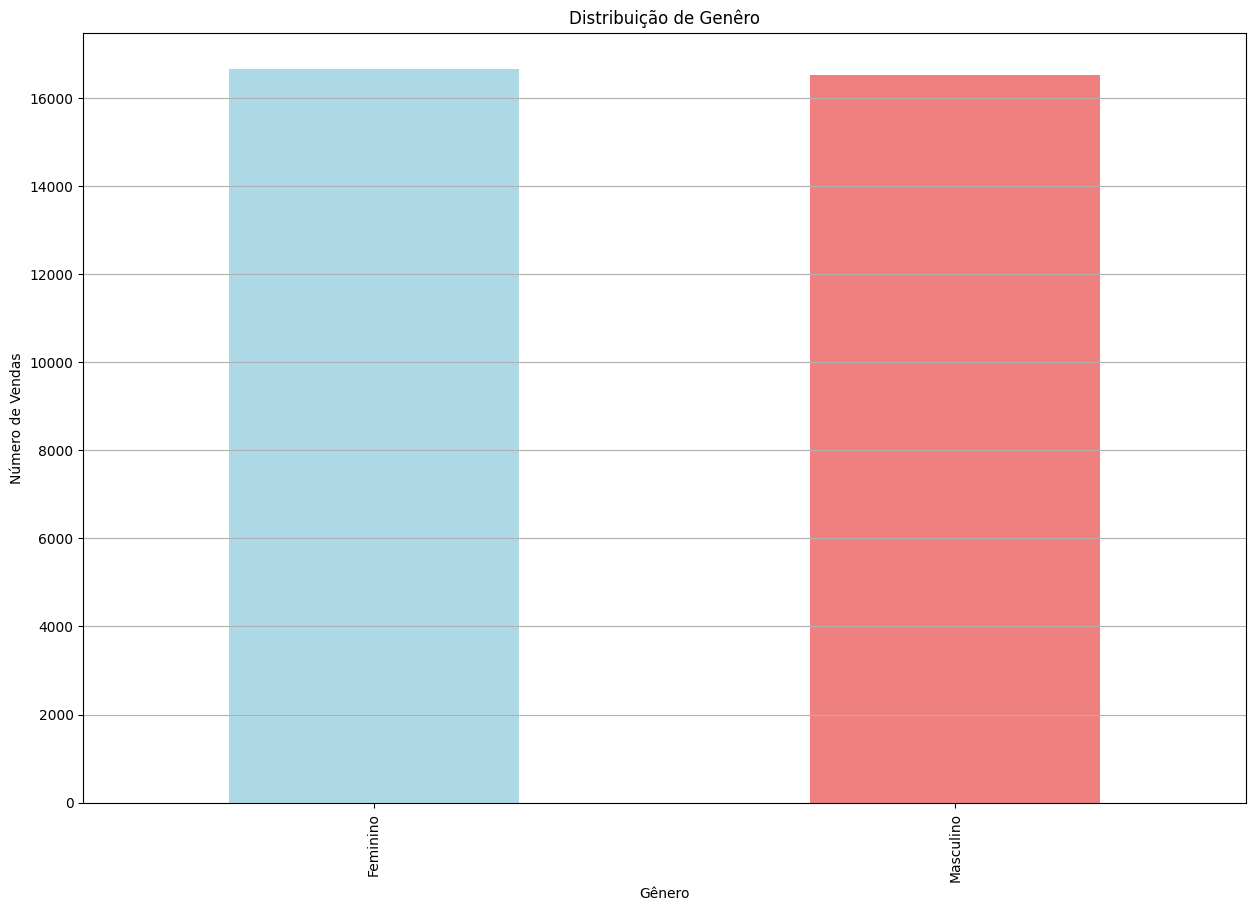

In [21]:
import matplotlib.pyplot as plt

distribuicao_genero = data['Gênero'].value_counts()

plt.Figure(figsize=(8, 6))
distribuicao_genero.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Distribuição de Genêro')
plt.xlabel('Gênero')
plt.ylabel('Número de Vendas')
plt.grid(axis='y')
plt.show()

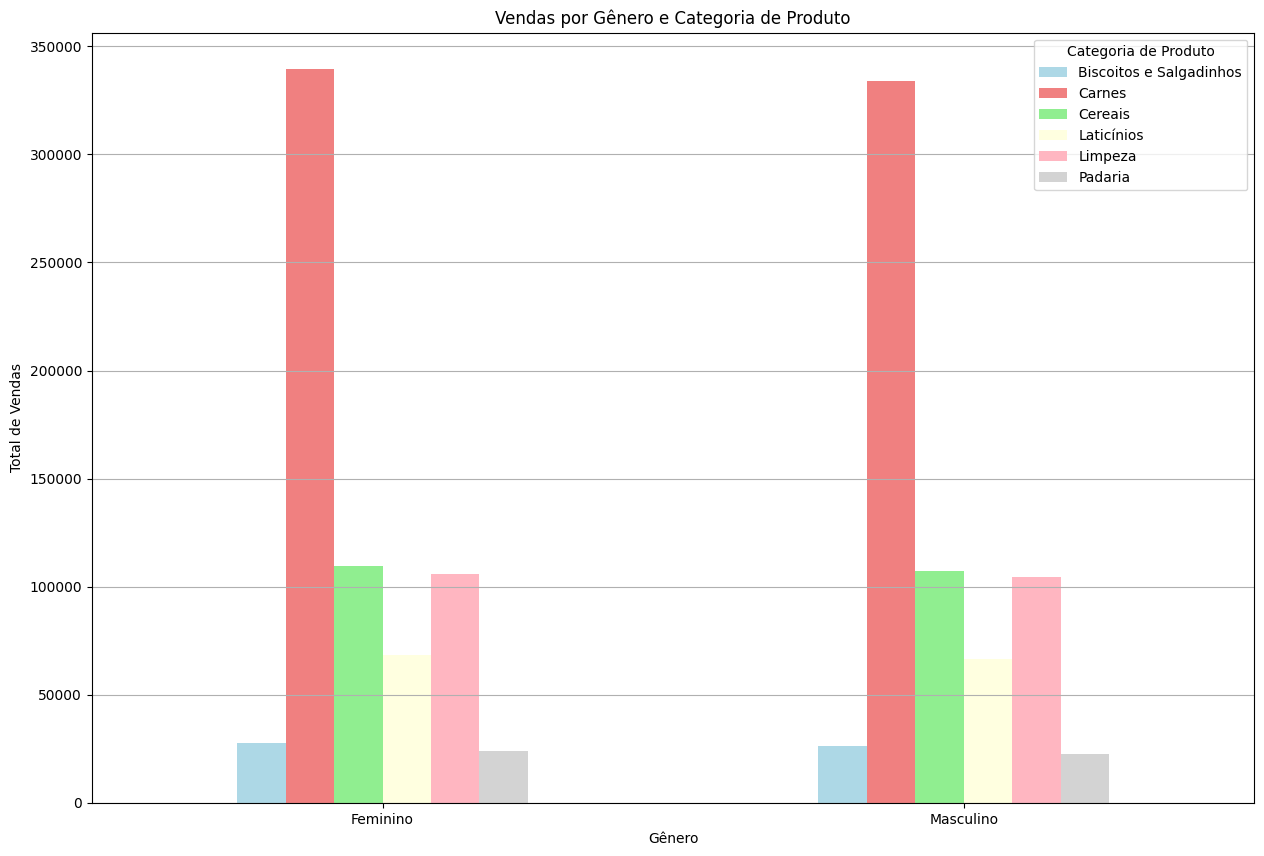

In [51]:
distribuicao_genero_categoria = data.groupby(['Gênero', 'Linha de Produto'])['Total'].sum().unstack()

plt.Figure(figsize=(8, 6))
distribuicao_genero_categoria.plot(
    kind='bar', 
    color=['#ADD8E6', '#F08080', '#90EE90', '#FFFFE0', '#FFB6C1', '#D3D3D3']
)

plt.title('Vendas por Gênero e Categoria de Produto')
plt.xlabel('Gênero')
plt.ylabel('Total de Vendas')
plt.legend(title='Categoria de Produto')
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y')
plt.show()